# Requirements

In [1]:
import time
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jax

# Simple functions

In [2]:
# jax

def rosenbrock(x):
    return (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2

def beale(x):
    return (
        (1.5 - x[0] + x[0] * x[1]) ** 2
        + (2.25 - x[0] + x[0] * (x[1] ** 2)) ** 2
        + (2.625 - x[0] + x[0] * (x[1] ** 3)) ** 2
    )

def paraboloid(x):
    return x[0]**2 + x[1]**2

def fwd_ad_iteration(function, params, tangents):
    f_val, jvp = jax.jvp(function, (params,), (tangents,))

    return f_val, jvp*tangents

def rev_ad_terations(function, params, tangents=None):
    f_val, f_vjp = jax.vjp(function, *(params,))

    return f_val, f_vjp((1.0))[0]

func_dict = {
    "Paraboloid": paraboloid,
    "Beale": beale,
    "Rosenbrock": rosenbrock
}

ad_dict = {
    "Forward": fwd_ad_iteration,
    "Reverse": rev_ad_terations,
}

## Run experiments

In [3]:
logs = []

for exps in range(20):
    logs.append([])
    n_iterations = 2000
    for func_name, func in func_dict.items():
        print(f"Running function {func_name}")
        for ad_name, ad_func in ad_dict.items():
            print(f"\tRunning AD {ad_name}")
            lr = 1e-3
            
            params = np.array([0.5, 0.5])
            
            log = {
                "Iteration": [0],
                "Time":[0.0],
                "f(x, y)": [func(params)],
                "Function": [func_name],
                "AD mode": [ad_name],
                "x": [params[0]],
                "y": [params[1]],
            }

            start_time = time.perf_counter()
            for iteration in range(1, n_iterations):
                tangents = np.random.rand(2)
                f_val, grad = ad_func(func, params, tangents)

                params = params - lr*grad
                lr *= 0.9999
                current_time = time.perf_counter() - start_time

                log["Iteration"].append(iteration) 
                log["Time"].append(current_time) 
                log["f(x, y)"].append(f_val) 
                log["Function"].append(func_name) 
                log["AD mode"].append(ad_name) 
                log["x"].append(params[0]) 
                log["y"].append(params[1]) 
            
            print(f"\tElapsed time: {current_time}")
            logs[exps].append(pd.DataFrame(log))

    logs[exps] = pd.concat(logs[exps], ignore_index=True)

Running function Paraboloid
	Running AD Forward
	Elapsed time: 7.796146548000024
	Running AD Reverse
	Elapsed time: 11.156191035999996
Running function Beale
	Running AD Forward
	Elapsed time: 30.592401988000006
	Running AD Reverse
	Elapsed time: 41.765950851000014
Running function Rosenbrock
	Running AD Forward
	Elapsed time: 12.260391569000035
	Running AD Reverse
	Elapsed time: 17.61785419699993
Running function Paraboloid
	Running AD Forward
	Elapsed time: 6.837130004999949
	Running AD Reverse
	Elapsed time: 9.621239489000004
Running function Beale
	Running AD Forward
	Elapsed time: 28.571967042000097
	Running AD Reverse
	Elapsed time: 43.25041754200004
Running function Rosenbrock
	Running AD Forward
	Elapsed time: 12.795588038000005
	Running AD Reverse
	Elapsed time: 18.682825933999993
Running function Paraboloid
	Running AD Forward
	Elapsed time: 6.94395083500001
	Running AD Reverse
	Elapsed time: 10.695628358000022
Running function Beale
	Running AD Forward
	Elapsed time: 26.1144

In [4]:
logs = []

for file in glob.glob("./simple_func_results/no_optim_*.csv"):
    logs.append(pd.read_csv(file))

Index(['Unnamed: 0', 'Iteration', 'Time', 'f(x, y)', 'Function', 'AD mode',
       'x', 'y'],
      dtype='object')


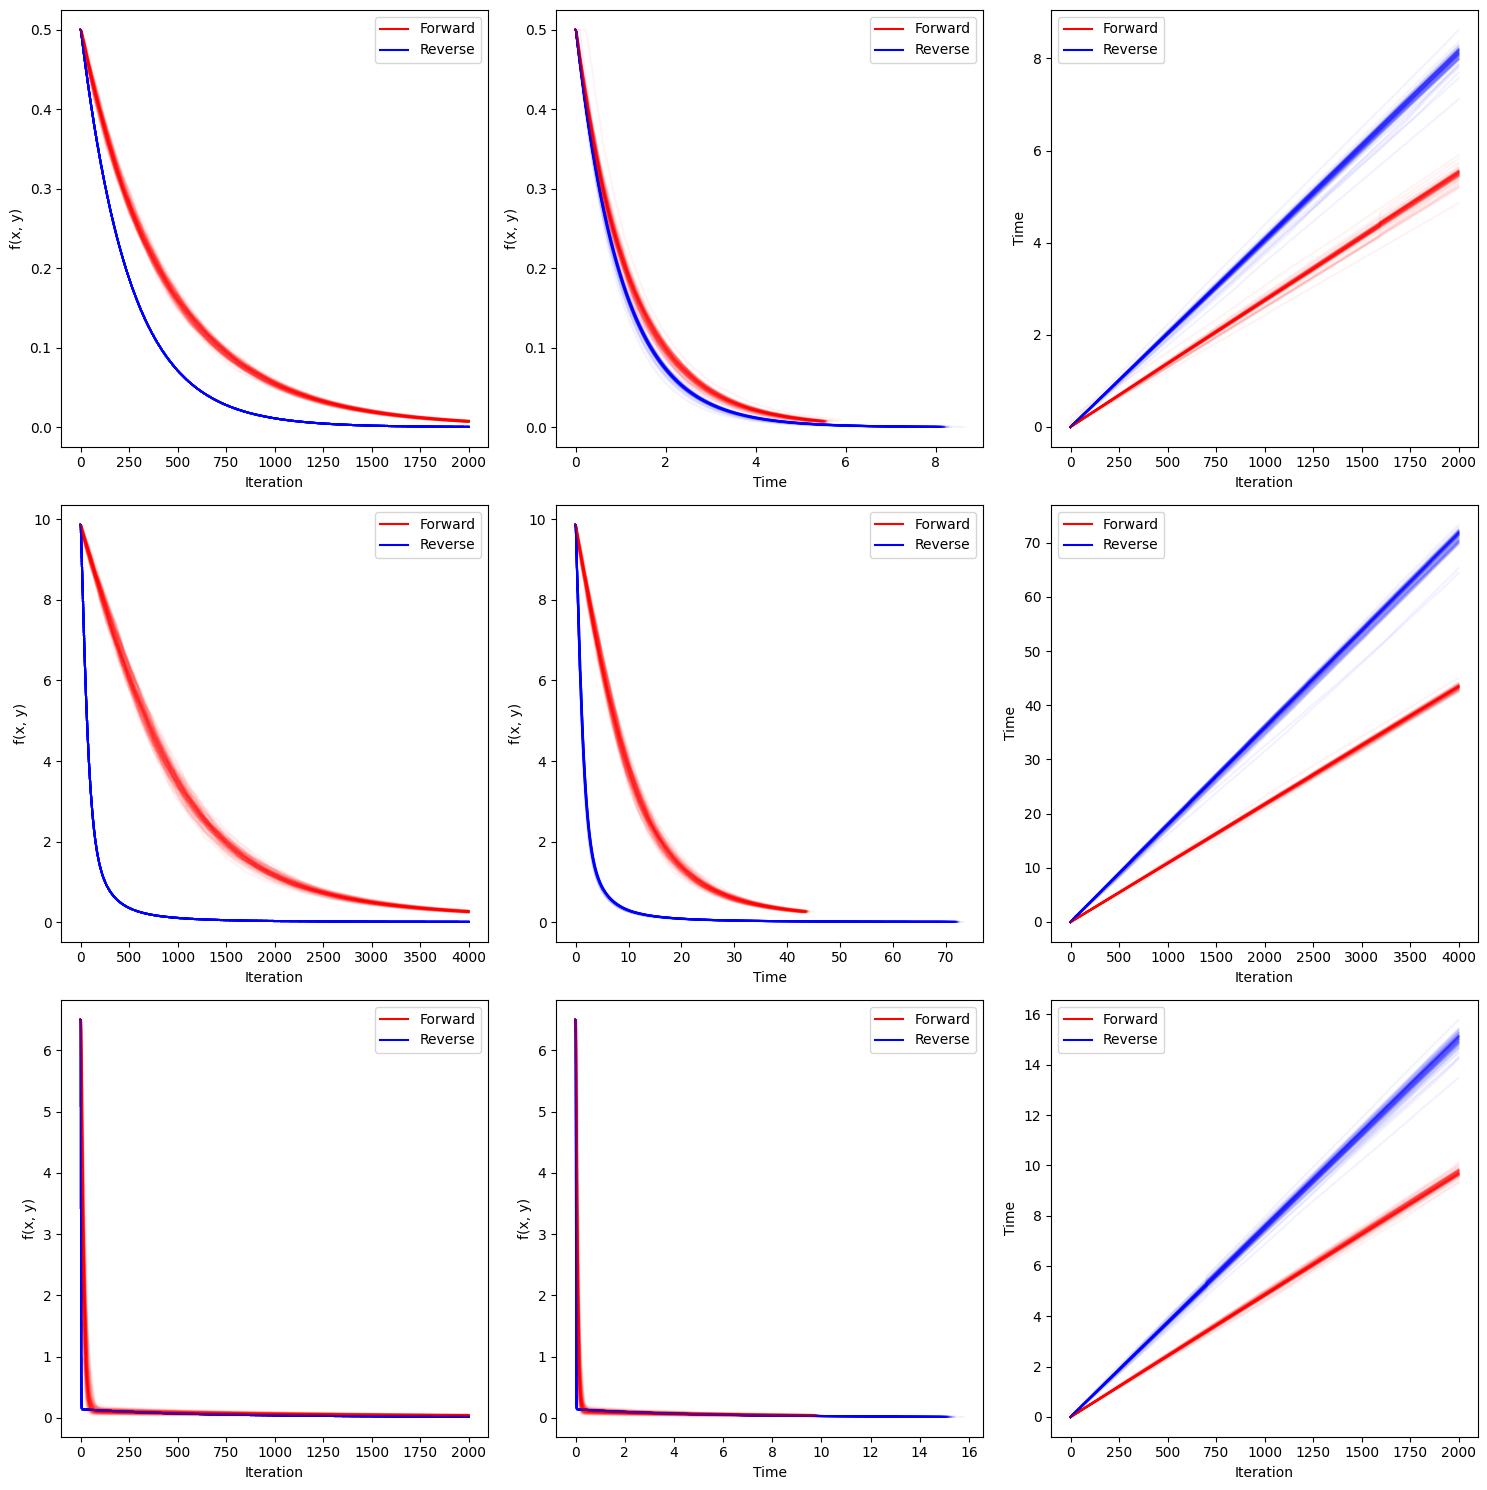

In [5]:
functions = logs[0]['Function'].unique()
ad_modes = logs[0]['AD mode'].unique()

print(logs[0].columns)

alpha=0.05
fig, axes = plt.subplots(nrows=len(functions), ncols=3, figsize=(15, 5 * len(functions)))

# Plot for each function
for i, function in enumerate(functions):
    for exp in range(len(logs)):
        function_data = logs[exp][logs[exp]['Function'] == function]

        # Plot 1: f(x, y) over Iteration
        axes[i, 0].plot(function_data[function_data['AD mode'] == ad_modes[0]]['Iteration'],
                    function_data[function_data['AD mode'] == ad_modes[0]]['f(x, y)'],
                    color='red', label=ad_modes[0], alpha=alpha)
        axes[i, 0].plot(function_data[function_data['AD mode'] == ad_modes[1]]['Iteration'],
                    function_data[function_data['AD mode'] == ad_modes[1]]['f(x, y)'],
                    color='blue', label=ad_modes[1], alpha=alpha)

        # Plot 2: f(x, y) over Time
        axes[i, 1].plot(function_data[function_data['AD mode'] == ad_modes[0]]['Time'],
                    function_data[function_data['AD mode'] == ad_modes[0]]['f(x, y)'],
                    color='red', label=ad_modes[0], alpha=alpha)
        axes[i, 1].plot(function_data[function_data['AD mode'] == ad_modes[1]]['Time'],
                    function_data[function_data['AD mode'] == ad_modes[1]]['f(x, y)'],
                    color='blue', label=ad_modes[1], alpha=alpha)

        # Plot 3: Time over Iteration
        axes[i, 2].plot(function_data[function_data['AD mode'] == ad_modes[0]]['Iteration'],
                    function_data[function_data['AD mode'] == ad_modes[0]]['Time'],
                    color='red', label=ad_modes[0], alpha=alpha)
        axes[i, 2].plot(function_data[function_data['AD mode'] == ad_modes[1]]['Iteration'],
                    function_data[function_data['AD mode'] == ad_modes[1]]['Time'],
                    color='blue', label=ad_modes[1], alpha=alpha)
        
    axes[i, 0].set_xlabel('Iteration')
    axes[i, 0].set_ylabel('f(x, y)')
    handles, labels = axes[i, 0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    leg = axes[i, 0].legend(by_label.values(), by_label.keys())
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    axes[i, 1].set_xlabel('Time')
    axes[i, 1].set_ylabel('f(x, y)')
    handles, labels = axes[i, 1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    leg = axes[i, 1].legend(by_label.values(), by_label.keys())
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    axes[i, 2].set_xlabel('Iteration')
    axes[i, 2].set_ylabel('Time')
    handles, labels = axes[i, 2].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    leg = axes[i, 2].legend(by_label.values(), by_label.keys())
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

# Adjust layout
plt.tight_layout()
plt.show()
plt.close()

## With adam

In [6]:
def adam_update(grad, v, s, iteration ,beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    new_v = beta1 * v + (1 - beta1) * grad
    v_corrected = new_v /(1 - beta1 ** iteration)

    new_s = beta2 * s + (1 - beta2) * np.square(grad)
    s_corrected = new_s /(1 - beta2 ** iteration)

    adapted_grad =  v_corrected /(np.sqrt(s_corrected) + epsilon)

    return adapted_grad, new_v, new_s

In [7]:
adam_logs = []

for exps in range(20):
    adam_logs.append([])
    n_iterations = 2000
    for func_name, func in func_dict.items():
        print(f"Running function {func_name}")
        for ad_name, ad_func in ad_dict.items():
            print(f"\tRunning AD {ad_name}")
            lr = 1e-3
            
            params = np.array([0.5, 0.5])

            v = np.zeros(params.shape)
            s = np.zeros(params.shape)

            log = {
                "Iteration": [0],
                "Time":[0.0],
                "f(x, y)": [func(params)],
                "Function": [func_name],
                "AD mode": [ad_name],
                "x": [params[0]],
                "y": [params[1]],
            }

            start_time = time.perf_counter()
            for iteration in range(1, n_iterations):
                tangents = np.random.rand(2)
                f_val, grad = ad_func(func, params, tangents)

                grad, v, s = adam_update(grad, v, s, iteration)

                params = params - lr*grad
                
                current_time = time.perf_counter() - start_time

                log["Iteration"].append(iteration) 
                log["Time"].append(current_time) 
                log["f(x, y)"].append(f_val) 
                log["Function"].append(func_name) 
                log["AD mode"].append(ad_name) 
                log["x"].append(params[0]) 
                log["y"].append(params[1]) 
            
            print(f"\tElapsed time: {current_time}")
            adam_logs[exps].append(pd.DataFrame(log))

    adam_logs[exps] = pd.concat(adam_logs[exps], ignore_index=True)

Running function Paraboloid
	Running AD Forward
	Elapsed time: 7.821723558000031
	Running AD Reverse
	Elapsed time: 11.145105953999973
Running function Beale
	Running AD Forward
	Elapsed time: 31.416022525000244
	Running AD Reverse
	Elapsed time: 46.52557885199985
Running function Rosenbrock
	Running AD Forward
	Elapsed time: 12.906425117999788
	Running AD Reverse
	Elapsed time: 18.39634061600009
Running function Paraboloid
	Running AD Forward
	Elapsed time: 7.200161059000038
	Running AD Reverse
	Elapsed time: 10.186231642000166
Running function Beale
	Running AD Forward
	Elapsed time: 29.018492485000024
	Running AD Reverse
	Elapsed time: 52.687102607999805
Running function Rosenbrock
	Running AD Forward
	Elapsed time: 14.208018970000012
	Running AD Reverse
	Elapsed time: 20.956039754999892
Running function Paraboloid
	Running AD Forward
	Elapsed time: 8.235418780000145
	Running AD Reverse
	Elapsed time: 10.36604384400016
Running function Beale
	Running AD Forward
	Elapsed time: 28.884

In [8]:

adam_logs = []

for file in glob.glob("./simple_func_results/adam_optim_*.csv"):
    adam_logs.append(pd.read_csv(file))

Index(['Unnamed: 0', 'Iteration', 'Time', 'f(x, y)', 'Function', 'AD mode',
       'x', 'y'],
      dtype='object')


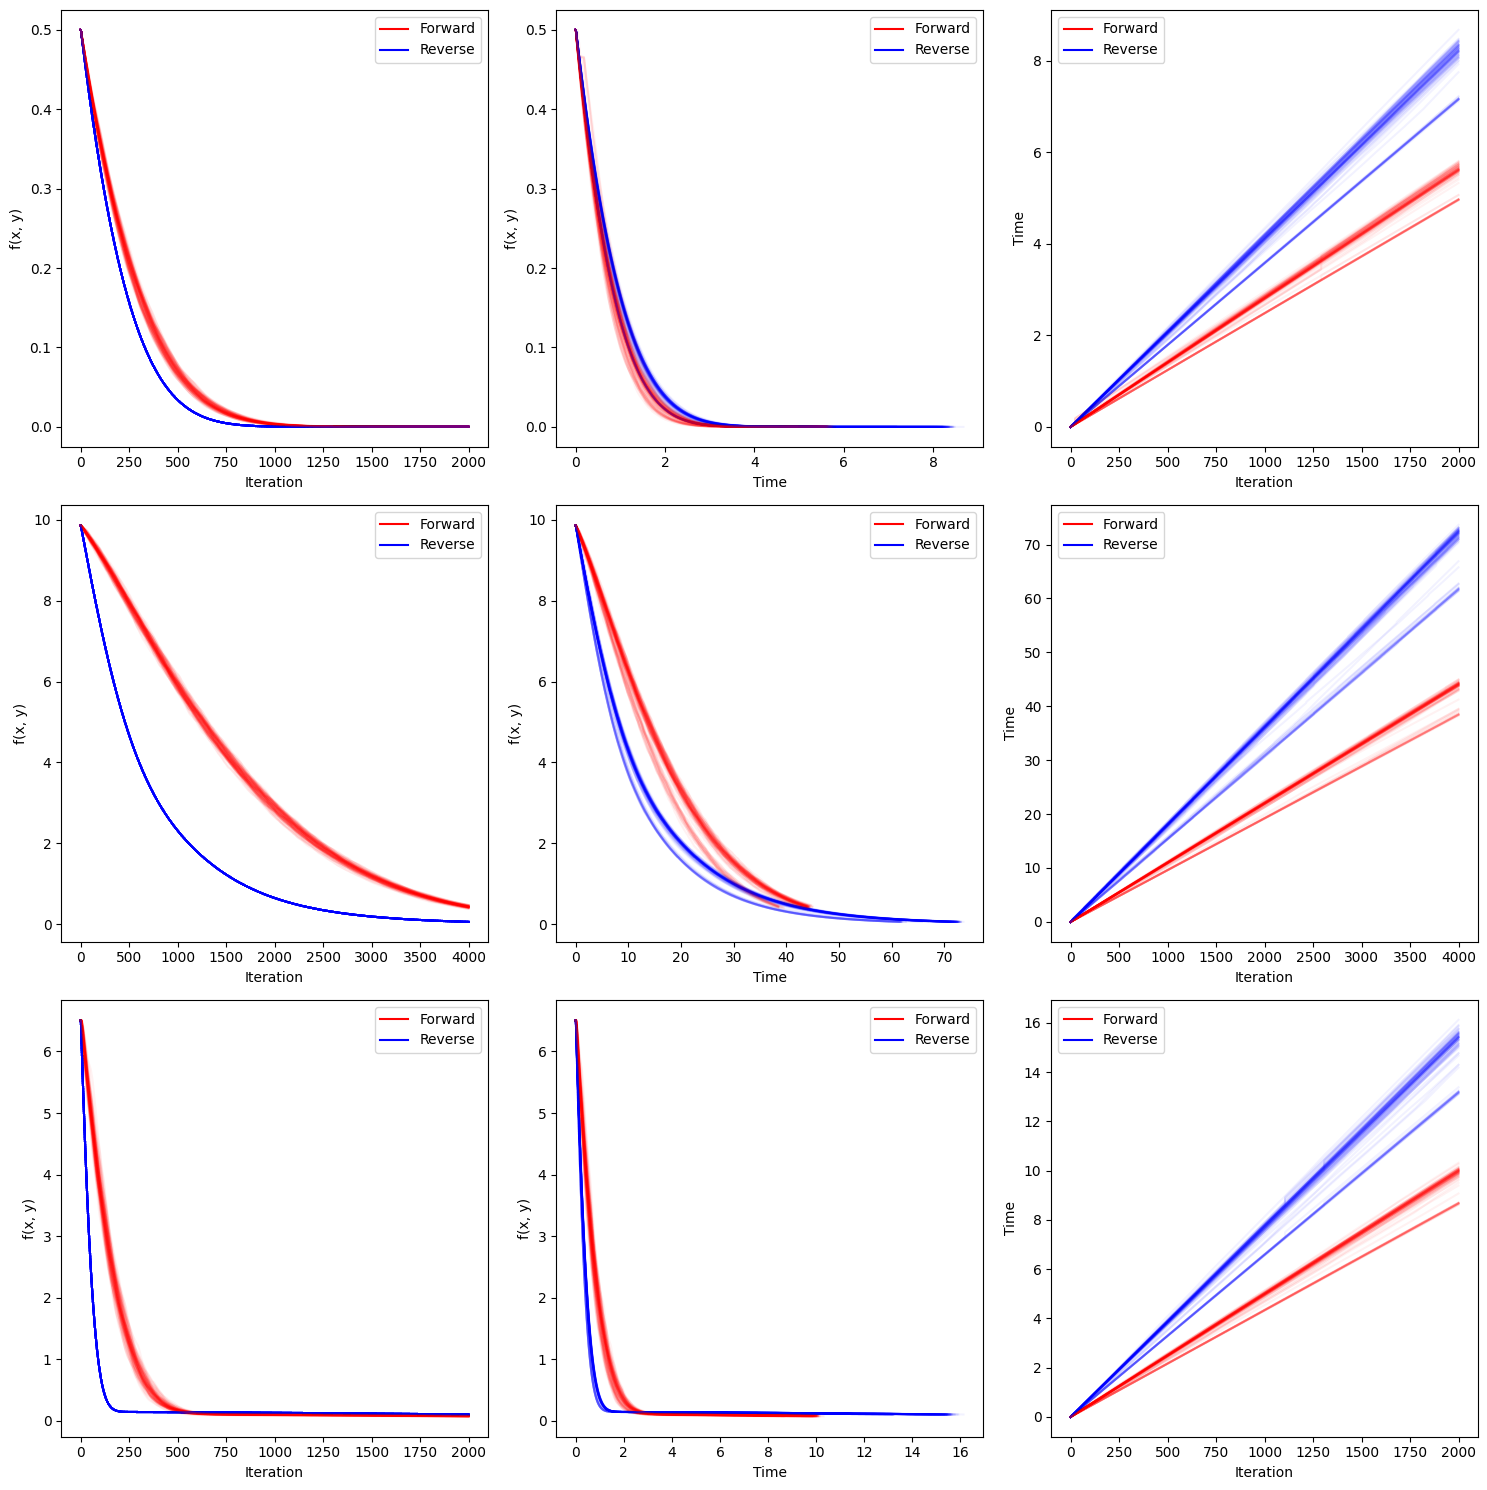

In [9]:
functions = adam_logs[0]['Function'].unique()
ad_modes = adam_logs[0]['AD mode'].unique()

print(adam_logs[0].columns)

alpha=0.05
fig, axes = plt.subplots(nrows=len(functions), ncols=3, figsize=(15, 5 * len(functions)))

# Plot for each function
for i, function in enumerate(functions):
    for exp in range(len(adam_logs)):
        function_data = adam_logs[exp][adam_logs[exp]['Function'] == function]

        # Plot 1: f(x, y) over Iteration
        axes[i, 0].plot(function_data[function_data['AD mode'] == ad_modes[0]]['Iteration'],
                    function_data[function_data['AD mode'] == ad_modes[0]]['f(x, y)'],
                    color='red', label=ad_modes[0], alpha=alpha)
        axes[i, 0].plot(function_data[function_data['AD mode'] == ad_modes[1]]['Iteration'],
                    function_data[function_data['AD mode'] == ad_modes[1]]['f(x, y)'],
                    color='blue', label=ad_modes[1], alpha=alpha)

        # Plot 2: f(x, y) over Time
        axes[i, 1].plot(function_data[function_data['AD mode'] == ad_modes[0]]['Time'],
                    function_data[function_data['AD mode'] == ad_modes[0]]['f(x, y)'],
                    color='red', label=ad_modes[0], alpha=alpha)
        axes[i, 1].plot(function_data[function_data['AD mode'] == ad_modes[1]]['Time'],
                    function_data[function_data['AD mode'] == ad_modes[1]]['f(x, y)'],
                    color='blue', label=ad_modes[1], alpha=alpha)

        # Plot 3: Time over Iteration
        axes[i, 2].plot(function_data[function_data['AD mode'] == ad_modes[0]]['Iteration'],
                    function_data[function_data['AD mode'] == ad_modes[0]]['Time'],
                    color='red', label=ad_modes[0], alpha=alpha)
        axes[i, 2].plot(function_data[function_data['AD mode'] == ad_modes[1]]['Iteration'],
                    function_data[function_data['AD mode'] == ad_modes[1]]['Time'],
                    color='blue', label=ad_modes[1], alpha=alpha)
        
    axes[i, 0].set_xlabel('Iteration')
    axes[i, 0].set_ylabel('f(x, y)')
    handles, labels = axes[i, 0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    leg = axes[i, 0].legend(by_label.values(), by_label.keys())
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    axes[i, 1].set_xlabel('Time')
    axes[i, 1].set_ylabel('f(x, y)')
    handles, labels = axes[i, 1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    leg = axes[i, 1].legend(by_label.values(), by_label.keys())
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    axes[i, 2].set_xlabel('Iteration')
    axes[i, 2].set_ylabel('Time')
    handles, labels = axes[i, 2].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    leg = axes[i, 2].legend(by_label.values(), by_label.keys())
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

# Adjust layout
plt.tight_layout()
plt.show()
plt.close()